<a href="https://colab.research.google.com/github/madhavamk/computational-data-science/blob/master/Assignments/M7_AST_05_Text_Mining_and_Analytics_B_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Assignment 5: ETL pipeline for Text Mining and Analytics

At the end of the experiment, you will be able to:

* perform text mining and analytics using Spark SQL functions
* use Spark’s built-in and external data sources to write data in different file formats as part of the extract, transform, and load (ETL) tasks


## Information

The basic terminology related to text analytics are

* **Text**: a sequence of words and punctuation
* **Corpus**: a large body of text
* **Frequency distribution**: the frequency of words in a text object
* **Collocation**: a sequence of words that occur together unusually often
* **Bigrams**: word pairs. High frequent bigrams are collocations
* **Text normalization**: the process of transforming text into a single canonical form, e.g., converting text to lowercase, removing punctuations and stop words.

### Introduction

Text analytics is the process of deriving information from text. It usually involves information retrieval, lexical analysis to study word frequency distributions, pattern recognition, tagging, information extraction, visualization, and predictive analytics. The overarching goal is, essentially, to turn text into data for analysis, via application of natural language processing (NLP), different types of algorithms and analytical methods.

Here we will consider `milton-paradise.txt` text file from Gutenberg corpus to do text mining and analytics. Starting from data extraction, we will perform various transformations on text including tokenization, the number of words counting, POS tagging, chunking and then store it in different file formats.

### Setup Steps:

In [53]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "" #@param {type:"string"}

In [54]:
#@title Please enter your password (your registered phone number) to continue: { run: "auto", display-mode: "form" }
password = "" #@param {type:"string"}

In [7]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()

notebook= "M7_AST_05_Text_Mining_and_Analytics_B" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://cds-iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError
    else:
      return Answer
  except NameError:
    print ("Please answer Question")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


### Install Pyspark

In [8]:
!pip install pyspark

### Import required packages

In [9]:
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import pandas as pd
import string
from pyspark.ml.feature import NGram
from pyspark.ml import Pipeline
from pyspark.sql.types import *
from pyspark.sql.functions import *
import nltk

### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. Instead of having various context, everything is now encapsulated in a Spark session.

In [10]:
# Start spark session
spark = SparkSession.builder.appName('ETL text data').getOrCreate()
spark

### Text Analytics

#### Get the text data

The raw text is from the Gutenberg corpus from the nltk package. Get file ids in Gutenberg corpus.

In [11]:
nltk.download('gutenberg')

# Download dependencies for sent_tokenize()
nltk.download('punkt_tab')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
from nltk.corpus import gutenberg
gutenberg_fileids = gutenberg.fileids()
gutenberg_fileids

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

The file id is `milton-paradise.txt`. Use the nltk.sent_tokenize() function to split text into sentences.

In [13]:
milton_paradise = gutenberg.raw('milton-paradise.txt')

pdf = pd.DataFrame({'sentences': nltk.sent_tokenize(milton_paradise)})
d = spark.createDataFrame(pdf)
d.show(1, truncate= False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentences                                                                                                                                                                                                                                    

From above it can be seen that empty spaces are present in the data.

#### Transform Data

* Remove trailing spaces

In [14]:
# Transform data
d_x = d.withColumn("sentences", regexp_replace(col("sentences"), "\\n+",""))
d_x.show(5, truncate= False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentences                                                                                                                                                                                                                                                                              

In [15]:
# Transform data
d1 = d.withColumn("sentences", regexp_replace(col("sentences"), "\\s+"," "))       # replace all spaces with with one space
# # YOUR CODE HERE to change d1                           # remove trailing spaces ["   Spark", "Spark  ", " Spark"]
d1.show(5, truncate= False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentences                                                                                                                                                                                                                                                                                  

In [ ]:
# # Transform data
# d1 = d.withColumn("sentences", regexp_replace(col("sentences"), "\\s+","_"))         # replace all spaces with underscore
# # YOUR CODE HERE to change d1                                                        # replace all underscores with one space
# d1 = d1.withColumn("sentences", trim(col("sentences")))                              # remove trailing spaces

In [16]:
d1.show(5, truncate= False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentences                                                                                                                                                                                                                                                                                  

In [ ]:
# Check for empty lines
# YOUR CODE HERE

##### Word Tokenization

It is the process of breaking down a paragraph, a sentence or a complete text corpus into an array of words.

In [18]:
from nltk.tokenize import word_tokenize

word_udf = udf(lambda x: word_tokenize(x), ArrayType(StringType()))
d2 = d1.withColumn("words", word_udf("sentences"))

In [19]:
# YOUR CODE HERE to display first five rows of d2
d2.show(5)

+--------------------+--------------------+
|           sentences|               words|
+--------------------+--------------------+
|[Paradise Lost by...|[[, Paradise, Los...|
|And chiefly thou,...|[And, chiefly, th...|
|Say first--for He...|[Say, first, --, ...|
|Who first seduced...|[Who, first, sedu...|
|Th' infernal Serp...|[Th, ', infernal,...|
+--------------------+--------------------+
only showing top 5 rows



From above it can be seen that data has punctuations in it.

* **Remove punctuation and stopwords**

In [17]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{"didn't", "you'd", 'of', 'off', 'can', 'as', 'no', 'until', "wouldn't", 'theirs', 'below', 'what', 'mustn', 'that', 'having', 'these', 'too', 'hers', 'just', 'i', 'some', 'and', 'from', 'will', 'up', 'him', 'do', 'or', 'through', 'under', 's', 'an', 'themselves', 'other', 'so', "hadn't", 'there', 'before', 'on', 'during', 'such', 'itself', 'had', 'is', 'again', 'very', "weren't", 'ma', 'not', 'your', 'only', 'ourselves', 'whom', 't', 'm', 'doing', 'all', 'our', "aren't", 'me', 'how', 'once', "won't", 'was', 'further', 'hasn', 'herself', 'between', 'into', 'y', 'didn', 'himself', 'here', 'been', 'above', 'because', 'am', 'wouldn', 'be', 'them', 'this', 'which', 'at', 'haven', 'have', 'has', 'about', 'why', 'should', "isn't", 'did', 'after', 'where', 'wasn', 'does', 'myself', 'don', "should've", 'with', 'its', "shan't", 'my', "she's", 'who', 'shouldn', "you'll", 'weren', "it's", 'most', 'those', 'couldn', "needn't", 'shan', 'then', 'yourself', 'while', 'by', "mightn't", 'being', 'any', 

In [21]:
# YOUR CODE HERE punctuations
punctuation = string.punctuation

In [22]:
# Transform data
punct_udf = udf(lambda x: [w for w in x if not w.lower() in punctuation if not w.lower() in stop_words])
# YOUR CODE HERE to create d3 by applying punct_udf function on words column of d2 and naming it as words column only
d3 = d2.withColumn("words", punct_udf("words"))

d3.show(5)

+--------------------+--------------------+
|           sentences|               words|
+--------------------+--------------------+
|[Paradise Lost by...|[Paradise, Lost, ...|
|And chiefly thou,...|[chiefly, thou, S...|
|Say first--for He...|[Say, first, --, ...|
|Who first seduced...|[first, seduced, ...|
|Th' infernal Serp...|[Th, infernal, Se...|
+--------------------+--------------------+
only showing top 5 rows



In [23]:
# Convert dataframe column to arraytype for further processing

array_udf = udf(lambda x: x, ArrayType(StringType()))
d4 = d3.withColumn("words", array_udf("words"))
d4.show(5)

+--------------------+--------------------+
|           sentences|               words|
+--------------------+--------------------+
|[Paradise Lost by...|[Paradise, Lost, ...|
|And chiefly thou,...|[chiefly, thou, S...|
|Say first--for He...|[Say, first, --, ...|
|Who first seduced...|[first, seduced, ...|
|Th' infernal Serp...|[Th, infernal, Se...|
+--------------------+--------------------+
only showing top 5 rows



##### Ngrams and collocations

Collocation is a sequence of words that occur together unusually often.
Bigrams: word pairs. High frequent bigrams are collocations.

Let's see how we transform texts to 2-grams, 3-grams, and 4-grams collocations.

In [24]:
ngrams = [NGram(n=n, inputCol='words', outputCol=str(n)+'-grams') for n in [2,3,4]]

# build pipeline model
pipeline = Pipeline(stages=ngrams)

# transform data
# YOUR CODE HERE to create 'texts_ngrams' by fitting and transforming d4 on pipeline
texts_ngrams = pipeline.fit(d4).transform(d4)

In [25]:
# display result
texts_ngrams.select('2-grams').show(6, truncate=False)
texts_ngrams.select('3-grams').show(6, truncate=False)
# YOUR CODE HERE using '4-grams'
texts_ngrams.select('4-grams').show(6, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

* Add the number of words column

In [26]:
# Transform data
len_udf = udf(lambda x: len(x), IntegerType())

d5 = d4.withColumn("no_of_words", len_udf("words"))

In [27]:
# YOUR CODE HERE to display first five rows of d5
d5.show(5)

+--------------------+--------------------+-----------+
|           sentences|               words|no_of_words|
+--------------------+--------------------+-----------+
|[Paradise Lost by...|[Paradise, Lost, ...|         80|
|And chiefly thou,...|[chiefly, thou, S...|         43|
|Say first--for He...|[Say, first, --, ...|         31|
|Who first seduced...|[first, seduced, ...|          4|
|Th' infernal Serp...|[Th, infernal, Se...|         41|
+--------------------+--------------------+-----------+
only showing top 5 rows



##### **POS (part-of-speech) tagging**

It is a process of converting a sentence to forms – list of words, list of tuples (where each tuple is having a form (word, tag)). The tag is a part-of-speech tag and signifies whether the word is a noun, adjective, verb, and so on.

To know more about POS tagging click [here](https://cdn.exec.talentsprint.com/static/cds/content/M7_AST5_pos.pdf).

In [28]:
# Download dependencies for pos_tag()
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [29]:
## define schema for returned result from the udf function
## the returned result is a list of tuples
schema = ArrayType(StructType([
            StructField('f1', StringType()),
            StructField('f2', StringType())    ]))

sent_to_tag_words_udf = udf(lambda x: nltk.pos_tag(x), schema)

In [30]:
# Transform data
d6 = d5.withColumn("tagged_words", sent_to_tag_words_udf("words"))
# YOUR CODE HERE to display first five rows of d6
d6.show(5)

+--------------------+--------------------+-----------+--------------------+
|           sentences|               words|no_of_words|        tagged_words|
+--------------------+--------------------+-----------+--------------------+
|[Paradise Lost by...|[Paradise, Lost, ...|         80|[{Paradise, NN}, ...|
|And chiefly thou,...|[chiefly, thou, S...|         43|[{chiefly, NN}, {...|
|Say first--for He...|[Say, first, --, ...|         31|[{Say, NNP}, {fir...|
|Who first seduced...|[first, seduced, ...|          4|[{first, RB}, {se...|
|Th' infernal Serp...|[Th, infernal, Se...|         41|[{Th, NNP}, {infe...|
+--------------------+--------------------+-----------+--------------------+
only showing top 5 rows



##### **Frequency Distribution Plot**

It gives us information about the number of times a word has occurred within a sentence.

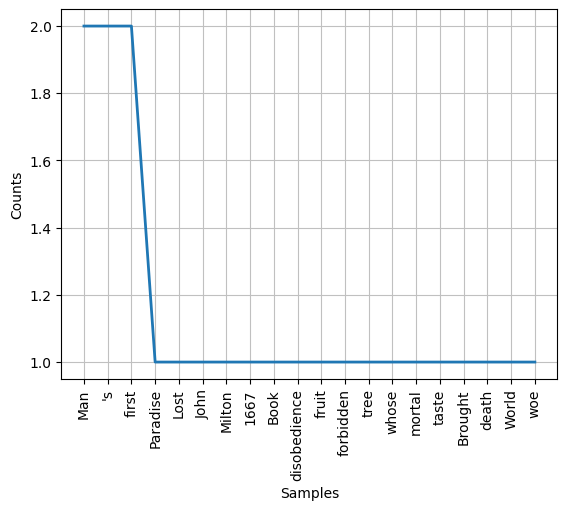

In [31]:
from nltk.probability import FreqDist

row = d6.select('words').toPandas().iloc[0,0]
fd = FreqDist(row)
# YOUR CODE HERE
fd.plot(20, cumulative=False)
plt.show()

From the above plot it can be seen that in the first row, the word 'Man' has occurred twice.

##### **Chunking**
Chunking is the process of grouping similar words together based on the nature of the word. It is the process of segmenting and labeling multitokens. Let's see how to do a noun phrase chunking on the tagged words data frame from the previous step.

First we need to define a udf function that chunks noun phrases from a list of pos-tagged words.

In [32]:
# define a udf function to chunk noun phrases from pos-tagged words
grammar = "NP: {<DT>?<JJ>*<NN>}"
chunk_parser = nltk.RegexpParser(grammar)
chunk_parser_udf = udf(lambda x: str(chunk_parser.parse(x)), StringType())

In [33]:
# Transform data
# YOUR CODE HERE to create d7 by applying chunk_parser_udf on 'tagged_words' column of d6 and naming it as 'NP_chunk' column
d7 = d6.withColumn("NP_chunk", chunk_parser_udf("tagged_words"))

In [34]:
d7.select('NP_chunk').show(1, truncate= False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Function to pretty-print chunks
def pretty_print_tree(chunk):
    try:
        tree = Tree.fromstring(chunk)  # Parse the chunk as an NLTK tree
        return tree.pformat(margin=200)  # Pretty print with a margin
    except Exception as e:
        return str(e)

# UDF to apply pretty-printing
pretty_print_udf = udf(pretty_print_tree, StringType())

# Apply UDF to create a new column with pretty-printed trees
d7_pretty = d7.withColumn("Pretty_Tree", pretty_print_udf(d7["NP_chunk"]))

row=d7_pretty.collect()[0]
print(row['Pretty_Tree'])

#### Load data

**Use Parquet file to store data**

In [35]:
d7.write.format("parquet").mode("overwrite").save("transformed_text_parquet_data")

**Read data from Parquet file**

In [36]:
df_text_parquet = spark.read.format("parquet").load("transformed_text_parquet_data")

In [37]:
# YOUR CODE HERE to display first five rows of df_text_parquet
df_text_parquet.show(5)

+--------------------+--------------------+-----------+--------------------+--------------------+
|           sentences|               words|no_of_words|        tagged_words|            NP_chunk|
+--------------------+--------------------+-----------+--------------------+--------------------+
|[Paradise Lost by...|[Paradise, Lost, ...|         80|[{Paradise, NN}, ...|(S\n  (NP Paradis...|
|And chiefly thou,...|[chiefly, thou, S...|         43|[{chiefly, NN}, {...|(S\n  (NP chiefly...|
|Say first--for He...|[Say, first, --, ...|         31|[{Say, NNP}, {fir...|(S\n  Say/NNP\n  ...|
|Who first seduced...|[first, seduced, ...|          4|[{first, RB}, {se...|(S first/RB seduc...|
|Th' infernal Serp...|[Th, infernal, Se...|         41|[{Th, NNP}, {infe...|(S\n  Th/NNP\n  i...|
+--------------------+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows



**Store the data as a `json file`**

In [38]:
d7.write.format("json").mode("overwrite").save('transformed_text_json_data.json')

**Read data from `json` to spark dataframe**

In [39]:
df_text_json = spark.read.format("json").load('transformed_text_json_data.json')

In [40]:
# YOUR CODE HERE to display first five rows of df_text_json
df_text_json.show(5)

+--------------------+-----------+--------------------+--------------------+--------------------+
|            NP_chunk|no_of_words|           sentences|        tagged_words|               words|
+--------------------+-----------+--------------------+--------------------+--------------------+
|(S\n  (NP Paradis...|         80|[Paradise Lost by...|[{Paradise, NN}, ...|[Paradise, Lost, ...|
|(S\n  (NP chiefly...|         43|And chiefly thou,...|[{chiefly, NN}, {...|[chiefly, thou, S...|
|(S\n  Say/NNP\n  ...|         31|Say first--for He...|[{Say, NNP}, {fir...|[Say, first, --, ...|
|(S first/RB seduc...|          4|Who first seduced...|[{first, RB}, {se...|[first, seduced, ...|
|(S\n  Th/NNP\n  i...|         41|Th' infernal Serp...|[{Th, NNP}, {infe...|[Th, infernal, Se...|
+--------------------+-----------+--------------------+--------------------+--------------------+
only showing top 5 rows



### Please answer the questions below to complete the experiment:




In [44]:
from collections import Counter
row_16 = d7.collect()[15]  # Remember, indexing starts from 0
words = row_16['words']
word_counts = Counter(words)
repeated_words = [word for word, count in word_counts.items() if count > 1]
num_repeated_words = len(repeated_words)
print(num_repeated_words)

1


In [46]:
# @title Considering the 16th row of transformed spark dataframe (d7), how many words occur more than once? { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "1" #@param ["","1","2","3"]

In [47]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [48]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "NA" #@param {type:"string"}


In [49]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [50]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [51]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [52]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 7546
Date of submission:  18 Jan 2025
Time of submission:  16:11:18
View your submissions: https://cds-iisc.talentsprint.com/notebook_submissions
